Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [2]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [83]:
# Other Imports
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

In [4]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

## Set up:

In [5]:
# Split train into train/val and make val the same size as test
target = 'status_group'
Tr, val = train_test_split(train, test_size=len(test),  
                              stratify=train[target], random_state=23)
Tr.shape,val.shape,test.shape

((45042, 41), (14358, 41), (14358, 40))

In [6]:
# Wrangle data the same way
def wrangler(X): 
  # prevent overwriting original
  X = X.copy()
  
  # replace outlier with zero
  X['latitude'] = X['latitude'].replace(-2e-08, 0)

  # drop duplicates and futiles
  duplicates = ['extraction_type','extraction_type_group','payment',
                'source_type', 'quality_group', 'quantity_group',
                'waterpoint_type_group','management']
  nugatory   = ['recorded_by','scheme_name']

  X = X.drop(columns= duplicates)
  X = X.drop(columns= nugatory)

  # Creating nans to be imputed later
  cols_with_zeros = ['longitude', 'latitude', 'population',
                      'gps_height', 'construction_year']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0, np.nan)  
  
  # Reduce cardinality of 'funder' feature 
  Top20funder = X['funder'].value_counts(normalize=True)[:20]
  X.loc[~X['funder'].isin(Top20funder), 'funder'] = 'Other'

  # And 'installer' feature
  Top20install = X['installer'].value_counts(normalize=True)[:20]
  X.loc[~X['installer'].isin(Top20install),'installer'] = 'Other'

  # Changing region and district code features to categorical features
  X['region_code'] = X['region_code'].astype(str)
  X['district_code'] = X['district_code'].astype(str)

  # Changing date recorded to datetime
  X['date_recorded'] = pd.to_datetime(X['date_recorded'], 
                                      infer_datetime_format=True)
  
  # Extracting year data from date recorded and dropping superfluous feature
  X['year_recorded'] = X['date_recorded'].dt.year
  X = X.drop(columns='date_recorded')

  # Engineering Age and Age_missing feature
  X['age'] = X['year_recorded'] - X['construction_year']
  X['age_MISSING'] = X['age'].isnull()

  return X

In [8]:
Train = wrangler(Tr)
Val   = wrangler(val)
Test  = wrangler(test)
Train.shape,Val.shape,Test.shape

((45042, 33), (14358, 33), (14358, 32))

In [9]:
# Feature Selection
# Drop columns intuitively deemed unnecessary
super = [target,'id','wpt_name','num_private','region_code','lga',
         'ward','public_meeting','payment_type']

# Remaining dataframe
train_features = Train.drop(columns=super)

# Get a list of the numeric features
numeric = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 100
categorical = cardinality[cardinality <= 100].index.tolist()

# Combine those lists 
features = numeric + categorical

In [11]:
# Arrange X and Y 
x_train = Train[features]
x_val   = Val[features]
x_test  = Test[features]

y_train = Train[target]
y_val   = Val[target]

## Model:

In [87]:
# Random Forest 
pipeline = make_pipeline(ce.OrdinalEncoder(),
                         IterativeImputer(max_iter=10,
                                          initial_strategy='mean',
                                          imputation_order='random', 
                                          random_state=23),
                         RandomForestClassifier(n_estimators= 300,
                                                max_depth=20,
                                                min_samples_leaf= 5,
                                                min_samples_split= 3, 
                                                n_jobs=-1, 
                                                random_state=23))
pipeline.fit(x_train,y_train)
RFpred = pipeline.predict(x_val)
pipeline.score(x_val,y_val)

0.8001114361331662

In [88]:
# Extra Trees
pipeline2 = make_pipeline(ce.OrdinalEncoder(),
                          IterativeImputer(max_iter=10,
                                           initial_strategy='mean',
                                           imputation_order='random',
                                           random_state=23),
                          ExtraTreesClassifier(n_estimators=400,
                                               max_depth=20,
                                               min_samples_split=5,
                                               min_samples_leaf=3,
                                               n_jobs=-1,
                                               random_state=23))                       
pipeline2.fit(x_train,y_train)
ETpred = pipeline2.predict(x_val)
pipeline2.score(x_val,y_val)

0.793634210892882

In [89]:
pipeline3 = make_pipeline(ce.OrdinalEncoder(),
                          IterativeImputer(max_iter=20,
                                           initial_strategy='mean',
                                           imputation_order='random',
                                           random_state=23),
                          LGBMClassifier(boosting_type='rf',
                                         n_estimators=300,
                                         objective='multiclass',
                                         learning_rate=0.1,
                                         subsample= 2,
                                         subsample_freq=4, 
                                         bagging_fraction=.4, 
                                         feature_fraction=0.5,
                                         random_state=23,
                                         n_jobs=-1))
pipeline3.fit(x_train,y_train)
LGBMpred = pipeline3.predict(x_val)
pipeline3.score(x_val,y_val)

0.7390305056414542

In [86]:
# Curious about the Voting Classifier...
Estimators = [('RF',pipeline),('LGBM',pipeline3),('ET',pipeline2)]
hardvote = VotingClassifier(estimators=Estimators,voting='hard')
softvote = VotingClassifier(estimators=Estimators,voting='soft')
hardvote.fit(x_train,y_train)
softvote.fit(x_train,y_train)
valpredh = hardvote.predict(x_val)
valpreds = softvote.predict(x_val)
print('Hard vote Accuracy:',accuracy_score(y_val,valpredh))
print('Soft vote Accuracy:',accuracy_score(y_val,valpreds))

Hard vote Accuracy: 0.7932163253935088
Soft vote Accuracy: 0.790639364814041


## Confusion Matrix:

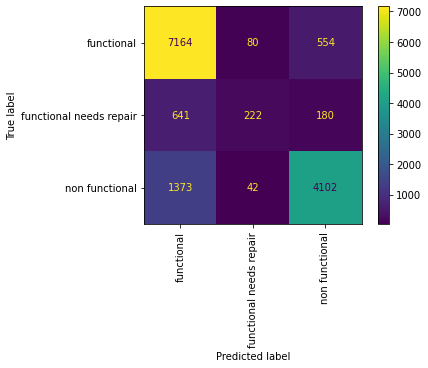

In [79]:
plot_confusion_matrix(pipeline, x_val, y_val, values_format='.0f', xticks_rotation='vertical');

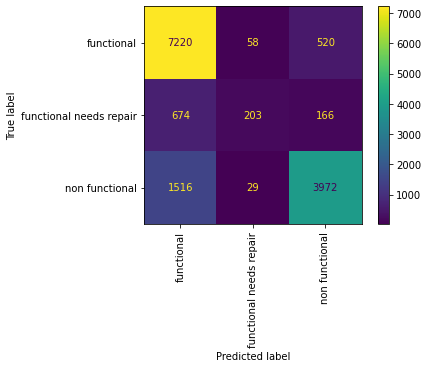

In [82]:
plot_confusion_matrix(pipeline2, x_val, y_val, values_format='.0f', xticks_rotation='vertical');

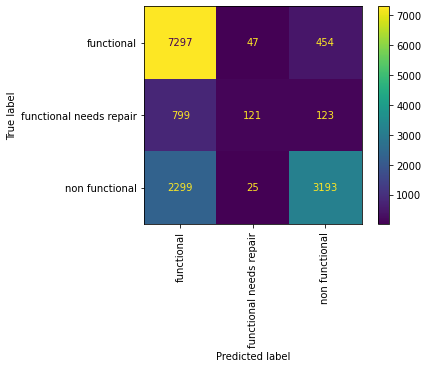

In [81]:
plot_confusion_matrix(pipeline3, x_val, y_val, values_format='.0f', xticks_rotation='vertical');

In [90]:
print(classification_report(y_val,RFpred))

                         precision    recall  f1-score   support

             functional       0.78      0.92      0.84      7798
functional needs repair       0.65      0.21      0.32      1043
         non functional       0.85      0.74      0.79      5517

               accuracy                           0.80     14358
              macro avg       0.76      0.63      0.65     14358
           weighted avg       0.80      0.80      0.79     14358



In [91]:
print(classification_report(y_val,ETpred))

                         precision    recall  f1-score   support

             functional       0.77      0.93      0.84      7798
functional needs repair       0.70      0.19      0.30      1043
         non functional       0.85      0.72      0.78      5517

               accuracy                           0.79     14358
              macro avg       0.77      0.61      0.64     14358
           weighted avg       0.80      0.79      0.78     14358



In [92]:
print(classification_report(y_val,LGBMpred))

                         precision    recall  f1-score   support

             functional       0.70      0.94      0.80      7798
functional needs repair       0.63      0.12      0.20      1043
         non functional       0.85      0.58      0.69      5517

               accuracy                           0.74     14358
              macro avg       0.73      0.54      0.56     14358
           weighted avg       0.75      0.74      0.71     14358



In [93]:
print(classification_report(y_val,valpredh))

                         precision    recall  f1-score   support

             functional       0.76      0.93      0.84      7798
functional needs repair       0.70      0.19      0.29      1043
         non functional       0.86      0.71      0.78      5517

               accuracy                           0.79     14358
              macro avg       0.77      0.61      0.64     14358
           weighted avg       0.80      0.79      0.78     14358

